# Extracting edge level noise features 

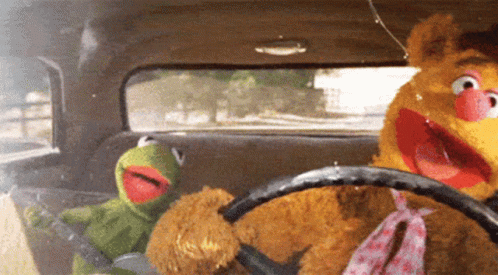 

This notebook details the process of extracting edge level noise features. It builds upon [`experimental/noise.ipynb`](/notebooks/experimental/birds.ipynb) & [`experimental/classifying_edges.ipynb`]('(/notebooks/experimental/classifying_edges.ipynb)'). It contains:

- Data
- Processing
- Prediction of unkown noise values
- Some extra various analyses

In [1]:
import pandas as pd
import ast

import geopandas as gpd
import contextily as cx
from shapely.geometry.polygon import Polygon
import osmnx as ox

import matplotlib.pyplot as plt 
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns


from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


#### Getting noise values on each edge (road) is a two-step job: 
- The noise data comes with a geometry of polygons, and the edges are linestrings, so the linestrings have to be mapped to the nearest polygon(s). However, the noise data only has information from Copenhagen municipality. 

- Frederiksberg, as well as some roads which not get mapped, are lacking these noise values. To overcome this, we implement a simple RandomForestRegressor to hopefully learn some characteristics about the data, that can be used to predict the noise value from the roads that lack the noise feature. 

## 1) Mapping linestrings to nearest polygons

### Data

The original noise data is visualized here: https://www.kk.dk/borger/affald-og-miljoe/stoej-stoev-og-luft/trafikstoej

The data is aquired from https://www.opendata.dk/city-of-copenhagen/vejstoej_2022 where the chosen dataset is the Nord2000. The reason for choosing Nord2000 over CNOSSOS is that "Miljøstyrelsen" ("The Danish Environmental Protection Agency") says the following:

*CNOSSOS er en simplere og overordnet set mindre nøjagtig model end den vi anvender i Danmark, nemlig beregningsmodellen Nord2000.*

This is roughly translated to:
*CNOSSOS is a simpler, and over all, less accurate model than the one we use in Denmark, namely the Nord2000 model of calculation.*

-----

The edges data comes from OSMNX, getting all roads in Copenhagen- and Frederiksberg municipality in the form of linestrings.

In [2]:
# Reading the data
gdf_noise = gpd.read_file('../data/raw/stoej.json')
gdf_roads = gpd.read_file('../data/raw/edges.json')

Since this data is located in Denmark, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [3]:
# Casting to new epsg in order to use meters in the buffer zone
gdf_noise = gdf_noise.to_crs(epsg=25832)
gdf_roads = gdf_roads.to_crs(epsg=25832)

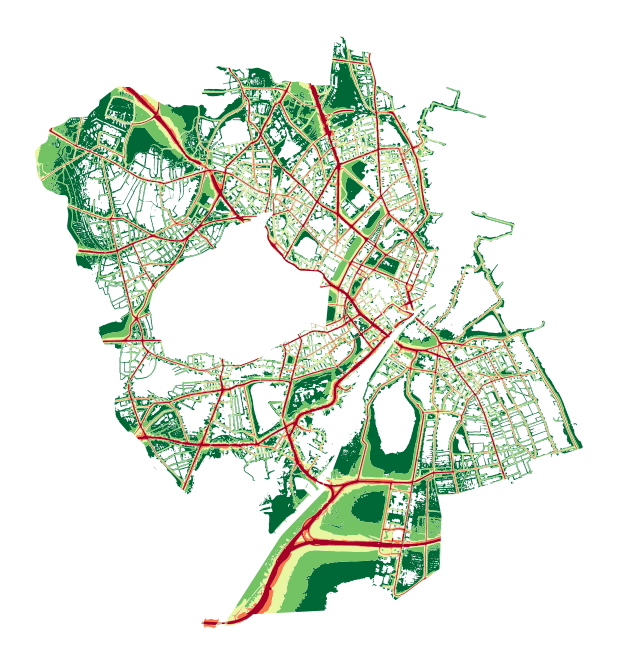

In [4]:
# plotting the predicted values and saving them
f, ax = plt.subplots(figsize=(12,12))
gdf_noise.plot(
    column='isov1',
    scheme='equal_interval',  # alternative: 'equal_interval'
    k=10,  
    linewidth = 0.01,
    cmap='RdYlGn_r',  
    ax=ax
)
ax.set_axis_off()


# plt.savefig('../pictures/street_noise_map_raw_data.png', bbox_inches='tight')


In [5]:
# Buffer the roads
gdf_roads['geometry'] = gdf_roads.geometry.buffer(10)

In [6]:
# Create a spatial index for the noise polygons. A technique to efficiently store and retrieve data based on their geographic location
noise_sindex = gdf_noise.sindex

In [7]:
# Intersect buffered roads with noise polygons using the spatial index and store intersection results
intersection_results = []
for road in tqdm(gdf_roads.itertuples(), total=len(gdf_roads), desc='Processing roads'):
    possible_matches_i = list(noise_sindex.intersection(road.geometry.bounds))
    possible_matches = gdf_noise.iloc[possible_matches_i]

    road_area = road.geometry.area
    for noise_polygon in possible_matches.itertuples():
        if road.geometry.intersects(noise_polygon.geometry):
            intersection = road.geometry.intersection(noise_polygon.geometry)
            
            if not intersection.is_empty:
                intersection_area = intersection.area

                intersection_results.append({
                    'road_id': road.id,
                    'road_length': road.geometry.length,
                    'noise_id': noise_polygon.id,
                    'intersection_area': intersection_area,
                    'road_area': road_area,
                    'noise_level': noise_polygon.isov1
                })

Processing roads: 100%|█████████████████████████████████████████████████████████| 61939/61939 [1:04:45<00:00, 15.94it/s]


In [8]:
# Convert the intersection results to a DataFrame
intersections_df = pd.DataFrame(intersection_results)

In [9]:
# Calculate the total intersection area for each road by summing up 
# the intersection areas of all noise polygons that intersect with the road.
intersection_sums = intersections_df.groupby('road_id')['intersection_area'].sum().reset_index()
intersection_sums.rename(columns={'intersection_area': 'total_intersection_area'}, inplace=True)


In [10]:
# Merge to get the total intersection area per road
intersections_df = intersections_df.merge(intersection_sums, on='road_id')

In [11]:
# Calculate normalized intersection percentage
intersections_df['intersection_percentage'] = intersections_df['intersection_area'] / intersections_df['total_intersection_area']

In [12]:
#Calculate weighted noise based on normalized intersection percentage
intersections_df['weighted_noise'] = intersections_df['noise_level'] * intersections_df['intersection_percentage']

In [13]:
# Group by road id to sum the weighted noise levels
road_noise = intersections_df.groupby('road_id')['weighted_noise'].sum().reset_index()

In [14]:
# Merge the noise information back to the original road dataset
gdf_roads['id'] = gdf_roads['id'].astype(str)  # Ensuring 'id' is of the same data type
road_noise['road_id'] = road_noise['road_id'].astype(str)  # Ensuring 'road_id' is of the same data type
gdf_roads = gdf_roads.merge(road_noise, left_on='id', right_on='road_id', how='left').drop(columns=['road_id'])

In [15]:
#Ensure the new 'weighted_noise' does not have NaNs (Frederiksberg data or none mapped linestrings)
gdf_roads['weighted_noise'] = gdf_roads['weighted_noise'].fillna(0)

Saving the first part of the data (no Frederiksberg data yet). 
This dataset will be used in the moddeling part

In [16]:
gdf_roads_file = gdf_roads[['id', 'weighted_noise','betweenness', 'geometry']]
gdf_roads_file.to_file('../data/noise_cph_no_frb.json')

In [17]:
#Taking a quick glance at the new noise values
gdf_roads_cph = gdf_roads[gdf_roads.weighted_noise > 0.0]
gdf_roads_cph.weighted_noise.describe().round(decimals=2)

count    45869.00
mean        60.48
std          5.86
min         53.00
25%         54.77
50%         59.78
75%         66.57
max         70.29
Name: weighted_noise, dtype: float64

-----
Visualizing all the streets that the mapped noice values

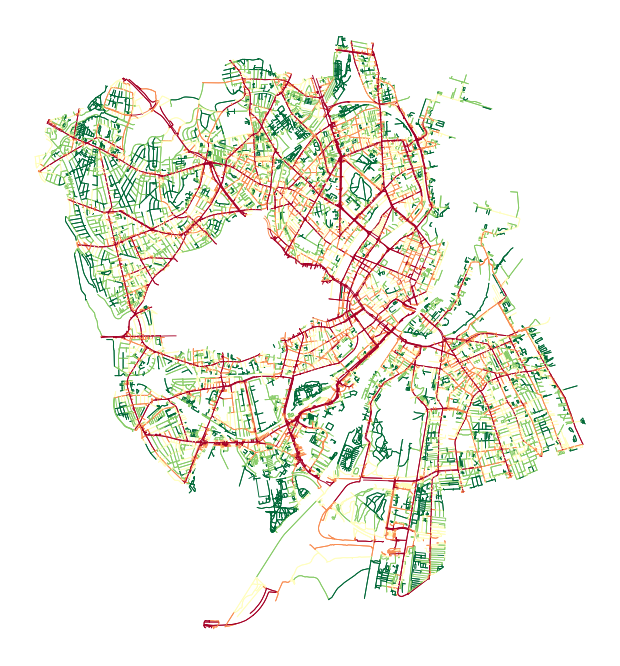

In [64]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_roads_cph.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

# cx.add_basemap(
#     ax, 
#     crs=gdf_roads_cph.crs,
#     source=cx.providers.CartoDB.DarkMatterNoLabels
# )

plt.savefig('../pictures/street_noise_map_no_frb.png')


Below are all the roads that did not get assigned any noise levels from the polygons. The big blue cluster is Frederiksberg, which was not part of the noise data. The rest is *probably* small edges that did not get a bigger enough buffer zone to match with any polygons.

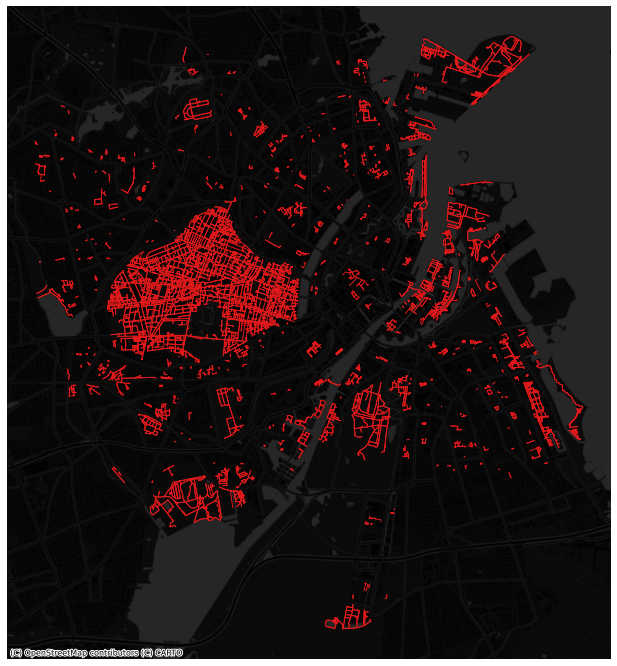

In [19]:
gdf_roads_no_data = gdf_roads[gdf_roads.weighted_noise == 0.0]


# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_roads_no_data.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='Set1',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_roads_no_data.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../pictures/street_noise_map_missing_roads.png')


## 2) Predicting noise values for linestrings that do not have them

Loading in the data

In [20]:
#Similar as the first part.
gdf_raw = gpd.read_file('../data/noise_cph_no_frb.json')
gdf_raw = gdf_raw.to_crs(epsg=25832)

The edges data, that we used in the first part, are lacking some features that could be useful for model prediction. Therefore, we query OSMNX again to get some features for each linestring.

We'll take a look at the features in a bit

In [21]:
#Getting meta data for each of the raods. Used to more accurate model the noise. 
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)

#Collabse hierachy structure
edges = edges.reset_index() 

### Data pre-processing

In gdf_raw, the "id" is a tuple of (u,v,key). In order to join gdf with the edges dataframe created above, we have to extract u,v,key from the tuble and cast it to new columns


In [22]:
gdf_raw['id_tuple'] = gdf_raw['id'].apply(ast.literal_eval)
gdf_raw['u'] = gdf_raw['id_tuple'].apply(lambda x: x[0])
gdf_raw['v'] = gdf_raw['id_tuple'].apply(lambda x: x[1])
gdf_raw['key'] = gdf_raw['id_tuple'].apply(lambda x: x[2])

# Dropping the temporary 'id_tuple' column 
gdf_raw.drop(columns=['id_tuple','id'], inplace=True)

In [23]:
#Merging the new linestring features with the original dataset.
gdf_raw = gdf_raw.merge(edges, how = "right", on=["u","v","key"])
gdf_raw = gdf_raw.dropna(subset=['weighted_noise', 'geometry_x']) #~1000 edges with out geometry. Will be dropped. Mismatch in edges.json and loading in the edges from osmnx. 

In [24]:
#Fill NaNs. This is a very naive approach, and a sort of imputation should be implemented instead.
#Currently, this machine learning part is only a small subset of a bigger project, so we use our time elsewhere
gdf_raw.fillna(0, inplace=True)

In [25]:
#The columns listed in the 'columns' list, are columns where some of the values are lists
#The RandomForestRegressor wont accept lists as an input, so we get the first value from the list instead

columns = ['highway', 'maxspeed', 'width', 'lanes']
for column in columns:
    gdf_raw[column] = gdf_raw[column].apply(lambda x: x[0] if isinstance(x, list) else x)

In [26]:
#The highway feature have various string features, which is not accepted by the model
#Therefore, we pick the 4 highest highway values by count, and then OneHot Encode them.
top_4_highways = gdf_raw['highway'].value_counts().nlargest(4).index
gdf_raw['highway'] = gdf_raw['highway'].apply(lambda x: x if x in top_4_highways else 'other')
gdf_processed = pd.get_dummies(gdf_raw, columns=['highway'])


In [27]:
#Defining which features to train on, and what feature to predict

features = [
    'length', 
    'betweenness', 
    'maxspeed', 
    'length', 
    'lanes',  
    'width',
    'highway_other',
    'highway_path',
    'highway_residential',
    'highway_service',
    'highway_tertiary'
]
target = 'weighted_noise'

In [28]:
#The below three features are of the dtype 'object' and need to be cast to an integer or float

gdf_processed['width'] = pd.to_numeric(gdf_processed['width'], errors='coerce')
gdf_processed['lanes'] = pd.to_numeric(gdf_processed['lanes'], errors='coerce')
gdf_processed['maxspeed'] = pd.to_numeric(gdf_processed['maxspeed'], errors='coerce')
gdf_processed.rename(columns={'geometry_x': 'geometry'}, inplace=True)
gdf_processed.drop(columns=['geometry_y'], inplace=True)

### Setting up the prerequisites for the model

In [29]:
# Separate rows with and without the target feature
train_data = gdf_processed[gdf_processed[target] > 0.0]
test_data = gdf_processed[gdf_processed[target] == 0.0]

X_train = train_data[features]
y_train = train_data[target]


X_test = test_data[features]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [30]:
X_train.dtypes #Ensure we do not have any 'object', 'str', or 'list' datatypes, as the RandomForestRegressor wont accept that

length                 float64
betweenness            float64
maxspeed                 int64
length                 float64
lanes                    int64
width                  float64
highway_other            uint8
highway_path             uint8
highway_residential      uint8
highway_service          uint8
highway_tertiary         uint8
dtype: object

### Training, evaluation, and prediction

In [31]:
model = RandomForestRegressor(n_estimators=100,  random_state=42, )
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = model.score(X_val, y_val)


print(f"RMSE: {rmse}, MAE: {mae}, r2: {r2}")

RMSE: 3.9283131812239014, MAE: 2.8037447407382596, r2: 0.5487245041614643


In [33]:
# Predict the missing values
predictions = model.predict(X_test)

# Assign the predicted values back to the test_data
test_data['predicted_noise'] = predictions

In [34]:
#The only columns we are interested in keeping
gdf_pred = test_data[['u','v','key','predicted_noise','geometry']]
gdf_pred = gpd.GeoDataFrame(gdf_pred, geometry='geometry')
gdf_pred.set_crs(epsg=25832, inplace=True)

u            v  key  predicted_noise  \
20          118744   1277939659    0        59.571128   
22          118744   1277939654    0        60.312829   
23      1277939659   6167979440    0        55.312464   
25      1277939659   6167979447    0        57.994244   
26      1277939654   6167979447    0        59.750719   
...            ...          ...  ...              ...   
62256  11733774733  11733774722    0        65.253100   
62260  11758063371       576735    0        68.688811   
62261  11758063371   6380887365    0        64.415495   
62262  11758063415  11758063371    0        68.777103   
62263  11758063415   6380887365    0        67.267342   

                                                geometry  
20     POLYGON ((723932.699 6174172.631, 723933.319 6...  
22     POLYGON ((723938.949 6174212.959, 723956.039 6...  
23     POLYGON ((723944.073 6174159.967, 723944.692 6...  
25     POLYGON ((723949.774 6174200.606, 723966.503 6...  
26     POLYGON ((723980.776 6174215.656, 723981.396 6...  
...                                                  ...  
62256  POLYGON ((721777.289 6176209.728, 721776.861 6...  
62260  POLYGON ((721410.627 6176169.975, 721410.918 6...  
62261  POLYGON ((721430.618 6176162.131, 721431.470 6...  
62262  POLYGON ((721406.416 6176154.188, 721408.766 6...  
62263  POLYGON ((721420.585 6176151.478, 721430.391 6...  

[15977 rows x 5 columns]

In [35]:
#Saving the predicted data 
gdf_pred.to_file('../data/raw/noise_frb_pred.json')

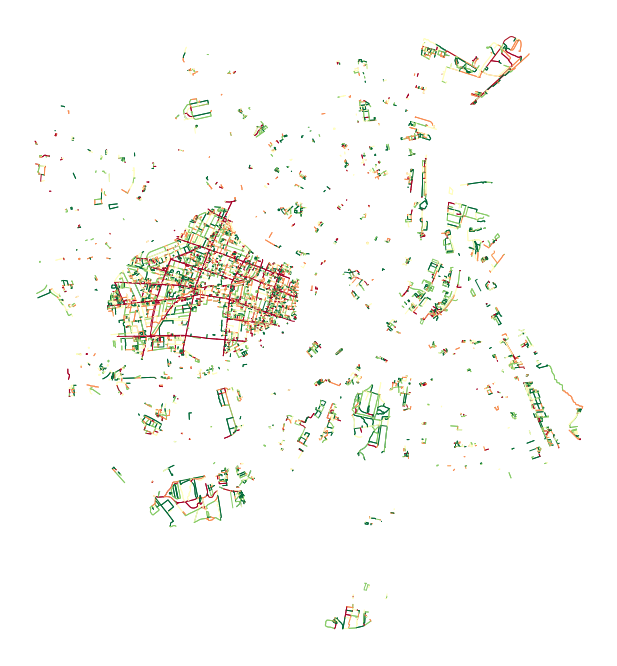

In [63]:
# plotting the predicted values and saving them
f, ax = plt.subplots(figsize=(12,12))
gdf_pred.plot(
    column='predicted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

# cx.add_basemap(
#     ax, 
#     crs=gdf_pred.crs,
#     source=cx.providers.CartoDB.DarkMatterNoLabels
# )

plt.savefig('../pictures/street_noise_map_frb_pred.png')


In [38]:
#Getting the original, none predicited data
gdf_cph = gdf_processed[gdf_processed.weighted_noise > 0.0]

#Casting the data to a geopandas dataframe
gdf_cph = gpd.GeoDataFrame(gdf_cph, geometry='geometry')
gdf_cph.set_crs(epsg=25832, inplace=True)

#Merge the predicted data and the original data together
gdf_combined = gdf_cph.merge(gdf_pred, on=['u','v','key'],how='outer')

In [39]:
#Currently we have two noise columns: weighted and predicted. 
#We want to keep them seperated, such that we always know what is original and what is predicted

#However, we also want a combined column. This is needed for the analysis, as we need one complete noise feature, and not two seperate
gdf_combined['combined_noise'] = gdf_combined['predicted_noise'].combine_first(gdf_combined['weighted_noise'])
gdf_combined['geometry'] = gdf_combined['geometry_x'].combine_first(gdf_combined['geometry_y'])


In [40]:
#Selecting only the features we need from the combined dataframe. 
#Notice how we do not need the geometry anymore. We have the id in the form of (u,v,key), which can at any time be matched to the edges.json

#And a dataframe for plotting later on
gdf_for_plt = gdf_combined[['u','v','key','weighted_noise', 'predicted_noise', 'combined_noise', 'geometry']]

#In the export version, geometry is not needed. It can be mapped with other geopandas dataframes via the id (u,vkey). 
gdf_export = gdf_combined[['u','v','key','weighted_noise', 'predicted_noise', 'combined_noise']]

gdf_export.to_csv('../data/noise_edges.csv',index=False)

In [41]:
#If we want to plot the combined data, we yet again have to ensure it's a geopandas dataframe with the proper crs:
gdf_for_plt = gpd.GeoDataFrame(gdf_for_plt, geometry='geometry')
gdf_for_plt.set_crs(epsg=25832, inplace=True)

u            v  key  weighted_noise  predicted_noise  \
0           118725    298795432    0       64.385753              NaN   
1           118725   6357644306    0       68.661369              NaN   
2        298795432    298795496    0       62.504355              NaN   
3       6357644306   2378383724    0       68.322808              NaN   
4       6357644306   6357644350    0       68.269927              NaN   
...            ...          ...  ...             ...              ...   
61400  11733774733  11733774722    0             NaN        65.253100   
61401  11758063371       576735    0             NaN        68.688811   
61402  11758063371   6380887365    0             NaN        64.415495   
61403  11758063415  11758063371    0             NaN        68.777103   
61404  11758063415   6380887365    0             NaN        67.267342   

       combined_noise                                           geometry  
0           64.385753  POLYGON ((724040.827 6175542.070, 724080.641 6...  
1           68.661369  POLYGON ((724046.688 6175575.314, 724054.375 6...  
2           62.504355  POLYGON ((724083.539 6175455.860, 724133.369 6...  
3           68.322808  POLYGON ((724068.742 6175594.599, 724069.480 6...  
4           68.269927  POLYGON ((724077.915 6175589.758, 724078.847 6...  
...               ...                                                ...  
61400       65.253100  POLYGON ((721777.289 6176209.728, 721776.861 6...  
61401       68.688811  POLYGON ((721410.627 6176169.975, 721410.918 6...  
61402       64.415495  POLYGON ((721430.618 6176162.131, 721431.470 6...  
61403       68.777103  POLYGON ((721406.416 6176154.188, 721408.766 6...  
61404       67.267342  POLYGON ((721420.585 6176151.478, 721430.391 6...  

[61405 rows x 7 columns]

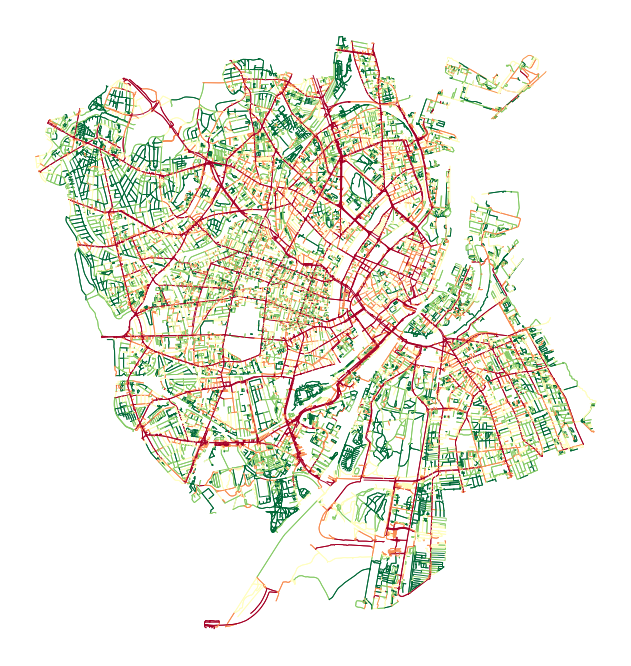

In [62]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_for_plt.plot(
    column='combined_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

# cx.add_basemap(
#     ax, 
#     crs=gdf_for_plt.crs,
#     source=cx.providers.CartoDB.DarkMatterNoLabels
# )

plt.savefig('../pictures/street_noise_map_final.png')


### Extra analysis and various plots

In [43]:
df = pd.read_csv('../data/noise_edges.csv')
gdf_noise = gpd.read_file('../data/raw/stoej.json')


In [44]:
wn = df[~df.weighted_noise.isna()]
pn = df[df.weighted_noise.isna()]

In [45]:
palette = sns.color_palette("coolwarm")


In [46]:
#Getting meta data for each of the raods. Used to more accurate model the noise. 
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)

#Collabse hierachy structure
edges = edges.reset_index() 

In [47]:
gdf_t = df.merge(edges, on=['u','v','key'],how='outer')

In [48]:
gdf_t = gpd.GeoDataFrame(gdf_t, geometry='geometry')
gdf_t.set_crs(epsg=25832, inplace=True)

u            v  key  weighted_noise  predicted_noise  \
0           118725    298795432    0       64.385753              NaN   
1           118725   6357644306    0       68.661369              NaN   
2        298795432    298795496    0       62.504355              NaN   
3       6357644306   2378383724    0       68.322808              NaN   
4       6357644306   6357644350    0       68.269927              NaN   
...            ...          ...  ...             ...              ...   
62442  11829253277  11829253278    0             NaN              NaN   
62443  11886461653  11834934599    0             NaN              NaN   
62444  11886461653  11834934657    0             NaN              NaN   
62445  11837321069  11837321086    0             NaN              NaN   
62446  11837321087  11837321086    0             NaN              NaN   

       combined_noise                    osmid  oneway              name  \
0           64.385753                 27226011    True  Banegårdspladsen   
1           68.661369                140412993    True     Vesterbrogade   
2           62.504355                244360867    True  Banegårdspladsen   
3           68.322808                678991574    True     Vesterbrogade   
4           68.269927                679140293    True     Vesterbrogade   
...               ...                      ...     ...               ...   
62442             NaN               1273936398   False               NaN   
62443             NaN               1274613261   False               NaN   
62444             NaN               1280544121    True               NaN   
62445             NaN  [1274879064, 327313131]   False        Grønvangen   
62446             NaN               1274879069   False               NaN   

                      highway  ...   length  \
0                    tertiary  ...  112.872   
1                    tertiary  ...   40.497   
2                    tertiary  ...   89.801   
3                    tertiary  ...   21.930   
4                    tertiary  ...   23.056   
...                       ...  ...      ...   
62442              pedestrian  ...   12.110   
62443                cycleway  ...   19.362   
62444                cycleway  ...   88.594   
62445  [residential, service]  ...   21.964   
62446                 service  ...   15.810   

                                                geometry lanes bridge  ref  \
0      LINESTRING (724025.025 6175551.339, 724031.889...   NaN    NaN  NaN   
1      LINESTRING (724025.025 6175551.339, 724051.956...     2    NaN  NaN   
2      LINESTRING (724075.369 6175450.104, 724076.732...   NaN    NaN  NaN   
3      LINESTRING (724059.919 6175572.112, 724075.704...     2    NaN  NaN   
4      LINESTRING (724059.919 6175572.112, 724081.508...     1    NaN  NaN   
...                                                  ...   ...    ...  ...   
62442  LINESTRING (724148.784 6175265.946, 724160.933...   NaN    NaN  NaN   
62443  LINESTRING (723790.304 6174588.639, 723792.301...   NaN    NaN  NaN   
62444  LINESTRING (723790.304 6174588.639, 723782.760...   NaN    NaN  NaN   
62445  LINESTRING (719712.098 6176675.435, 719709.131...   NaN    NaN  NaN   
62446  LINESTRING (719714.233 6176647.233, 719722.203...   NaN    NaN  NaN   

             service width access tunnel junction  
0                NaN   NaN    NaN    NaN      NaN  
1                NaN   NaN    NaN    NaN      NaN  
2                NaN   NaN    NaN    NaN      NaN  
3                NaN   NaN    NaN    NaN      NaN  
4                NaN   NaN    NaN    NaN      NaN  
...              ...   ...    ...    ...      ...  
62442            NaN   NaN    NaN    NaN      NaN  
62443            NaN     7    NaN    NaN      NaN  
62444            NaN   NaN    NaN    NaN      NaN  
62445  parking_aisle   NaN    NaN    NaN      NaN  
62446       driveway   NaN    NaN    NaN      NaN  

[62447 rows x 21 columns]

In [49]:
norm = TwoSlopeNorm(vmin=53, vcenter=60.2, vmax=70.3) #Ensuring the colour map always use the same ranges

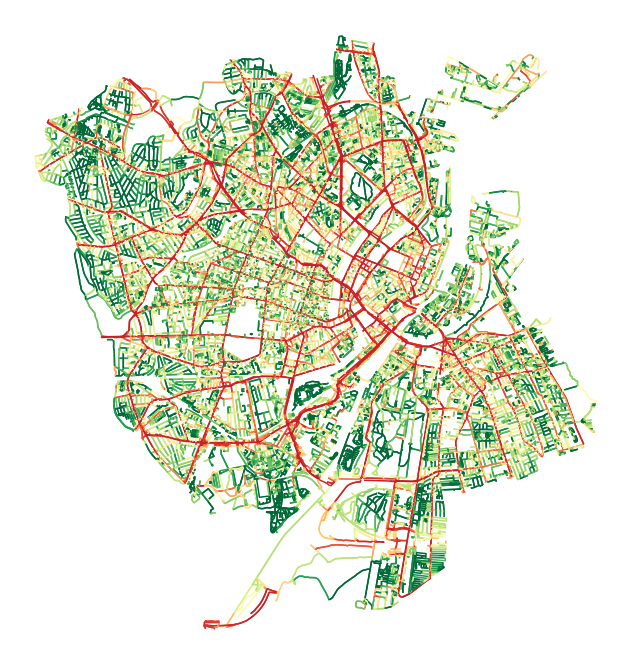

In [50]:
# plotting the predicted values and saving them
f, ax = plt.subplots(figsize=(12,12))
gdf_t.plot(
    column='combined_noise',
    k=5,
    cmap ='RdYlGn_r',
    norm = norm,
    ax=ax)
ax.set_axis_off()

# cx.add_basemap(
#     ax, 
#     crs=gdf_t.crs,
#     source=cx.providers.CartoDB.DarkMatterNoLabels
# )

plt.savefig('../pictures/street_noise_map_final.png', bbox_inches='tight')


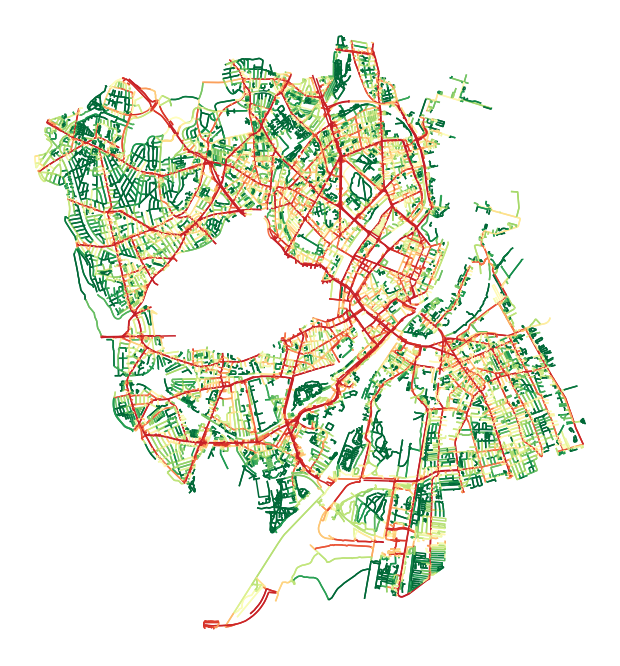

In [51]:
# plotting the predicted values and saving them
f, ax = plt.subplots(figsize=(12,12))
gdf_t.plot(
    column='weighted_noise',
    k=5,
    cmap ='RdYlGn_r',
    norm=norm,
    ax=ax)
ax.set_axis_off()

# cx.add_basemap(
#     ax, 
#     crs=gdf_t.crs,
#     source=cx.providers.CartoDB.DarkMatterNoLabels
# )

plt.savefig('../pictures/street_noise_map_no_frb.png', bbox_inches='tight')


Checking the areas of the polygons. Since we use epsg:25832 the metric used is meters, and thus the area is square meters. 

In [52]:
gdf_noise = gdf_noise.to_crs(epsg=25832)

In [53]:
gdf_noise['area'] = gdf_noise.geometry.area

In [54]:
gdf_noise.area.max() #The biggest polygon in the noise dataset

4771942.0060586715

In [55]:
gdf_noise.area.median() #Median area for all polygons

769.7392326100276

In [56]:
gdf_noise.area.min() #The smallest polygon

0.00016487375612669718

In [57]:
gdf_noise.sort_values(by=['isov1'], ascending=False, inplace=True)

In [58]:
#sns.set_style('whitegrid')

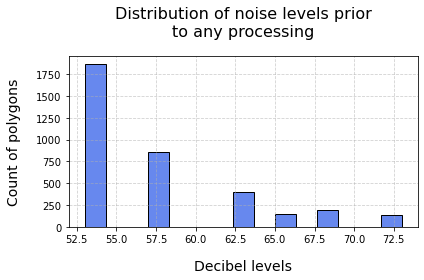

In [59]:
# Plot for noise levels prior to processing
f, ax = plt.subplots()
ax.hist(gdf_noise.isov1, bins=15, color=palette[0], edgecolor='black')
# ax.set_xlim(0.5, 1.025)
# ax.set_ylim(0, 700)
ax.set_xlabel('Decibel levels', fontsize=14, labelpad=15)
ax.set_ylabel('Count of polygons', fontsize=14, labelpad=15)
ax.set_title('Distribution of noise levels prior\nto any processing', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('../pictures/figures/polygons_decibel.png')

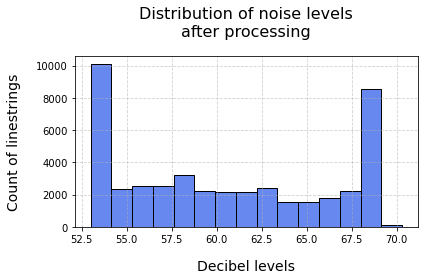

In [60]:
# Plot for noise levels after processing
f, ax = plt.subplots()
ax.hist(wn.weighted_noise, bins=15, color=palette[0], edgecolor='black')
# ax.set_xlim(0.5, 1.025)
# ax.set_ylim(0, 700)
ax.set_xlabel('Decibel levels', fontsize=14, labelpad=15)
ax.set_ylabel('Count of linestrings', fontsize=14, labelpad=15)
ax.set_title('Distribution of noise levels\nafter processing', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('../pictures/figures/linestrings_decibel.png')

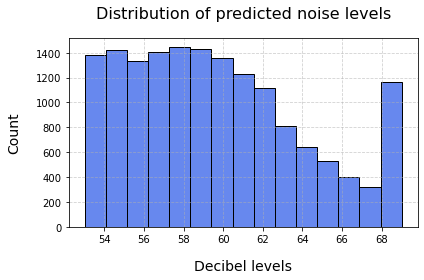

In [61]:
# Plot for predicted noise levels
f, ax = plt.subplots()
ax.hist(pn.predicted_noise, bins=15, color=palette[0], edgecolor='black')
# ax.set_xlim(0.5, 1.025)
# ax.set_ylim(0, 700)
ax.set_xlabel('Decibel levels', fontsize=14, labelpad=15)
ax.set_ylabel('Count', fontsize=14, labelpad=15)
ax.set_title('Distribution of predicted noise levels', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('../pictures/figures/predicted_decibel.png')